<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-11/causal_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will try out causal tree algorithm for estimating heterogeneous treatment effects, as developed by Susan Athey, Guido Imbens. The idea is that we don't only want to know the average treatment effect of shelter in place policy, but we want to know on **what kind of counties (what covariates) will benefit the most from the policy and what kind of counties benefit nothing from the policy**.

[The R code for causal tree](https://github.com/susanathey/causalTree)

In [1]:
cd drive/My\ Drive/covid/PSM/data

/content/drive/My Drive/covid/PSM/data


In [2]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
county_data_with_reduced_covariates_with_SIP.csv
final_data_google_and_safe_graph_up_to_6_1.csv
google_mobility.csv
social_dist_aggregated_on_county.csv


In [3]:
import pandas as pd
import numpy as np

In [4]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [5]:
# download causal tree package into colab environment.
%%R
install.packages("devtools")
library(devtools) 
install_github("susanathey/causalTree")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/devtools_2.3.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 373387 bytes (364 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

data.table (NA -> 1.13.2) [CRAN]
rpart.plot (NA -> 3.0.9 ) [CRAN]


R[write to console]: Installing 2 packages: data.table, rpart.plot

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/data.table_1.13.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 5282452 bytes (5.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

✔  checking for file ‘/tmp/RtmpgMLbb8/remotes3855c16794/susanathey-causalTree-4860476/DESCRIPTION’ (371ms)
─  preparing ‘causalTree’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘causalTree_0.0.tar.gz’
   


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
data = pd.read_csv('county_data_with_reduced_covariates_with_SIP.csv')

In [7]:
data.head()

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9


[1] 2
[1] "CT"


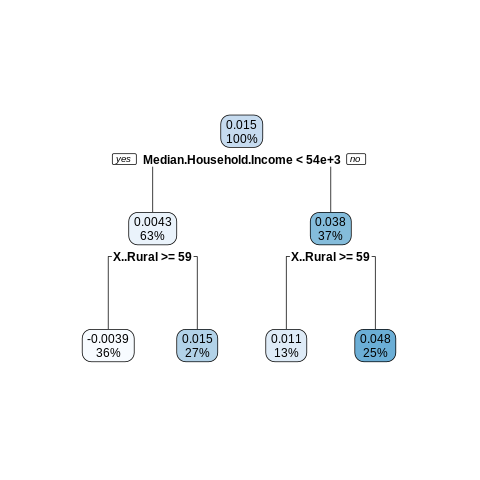

In [52]:
%%R -i data
library(causalTree)

response <- "diff_in_perc_at_home"
covariates <- c("Median.Household.Income", "X..Rural", "Population_y", "political_diff",
                "X..less.than.18.years.of.age", "X..65.and.over", "X..Asian", "X..Black",
                "X..Hispanic", "X..Non.Hispanic.White")
formula_string <- paste(response, paste(covariates, collapse=" + "), sep=" ~ ")
#> "diff_in_perc_at_home ~ Median.Household.Income + X..Rural + ..."

# This returns the formula:
formula <- as.formula(formula_string)

# minsize = minimum number of either treatment units or non-treatment units within
#           a leaf node of the tree - if set high we will get a shallow tree, if
#           we set low we will get a very deep tree.
# split.Rule = the risk function we use to figure out how to split the branch
#              there are 4 options.
# cv.option = the function used to cross validate.
# split.Honest = whether to use "Honest" evaluation, which really just means if we
#                are going to use cross validation to split the dataset into "training" and
#                "testing" sets, and only evaluate the accuracy of predicting causal effect
#                on the "testing" set.
# xval = fold of cross validation. xval = 10 means 10 fold cross validation.

# this function is forcing each leaf node to have at least 100 treatment units and 100 non-treatment
# units, which is a lot (we only have 400 - 500 non-SIP counties.)
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "CT", cv.option = "CT", split.Honest = T, cv.Honest = T,
                   split.Bucket = F, xval = 5, minsize = 100)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(opfit)

We we can see, there is a non-uniform treatment effects on counties based on their covariates - the counties which have higher income and less rural area benefit the most from the government's policy!

sometimes when I run the code above, I get a slightly different results. Is causal tree algorithm stochastic? If it is, where is the randomness?

[1] 2
[1] "CT"


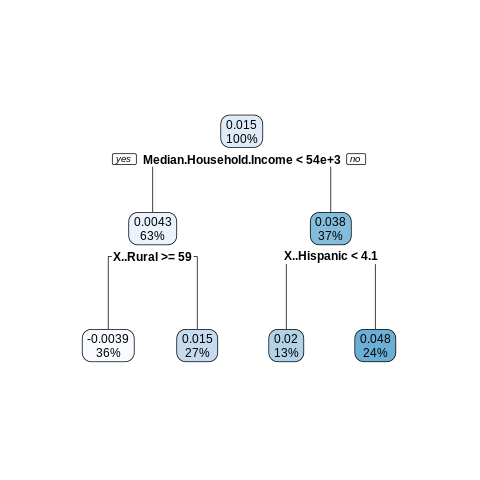

In [53]:
%%R
# let's try the same algorithm on a slightly less minsize.
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "CT", cv.option = "CT", split.Honest = T, cv.Honest = T,
                   split.Bucket = F, xval = 5, minsize = 75)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(opfit)

[1] 2
[1] "CT"


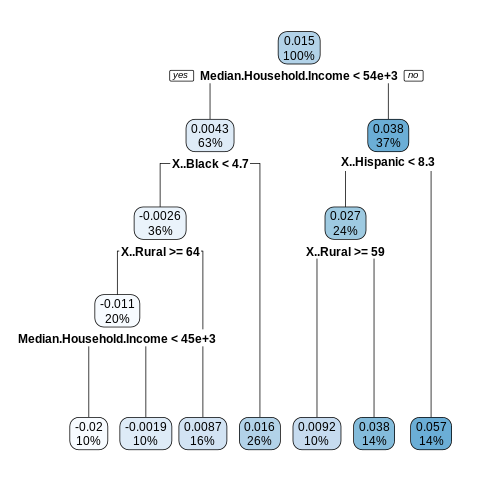

In [54]:
%%R
# let's try the same algorithm on a slightly less minsize.
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "CT", cv.option = "CT", split.Honest = T, cv.Honest = T,
                   split.Bucket = F, xval = 5, minsize = 50)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(opfit)

[1] 2
[1] "CT"


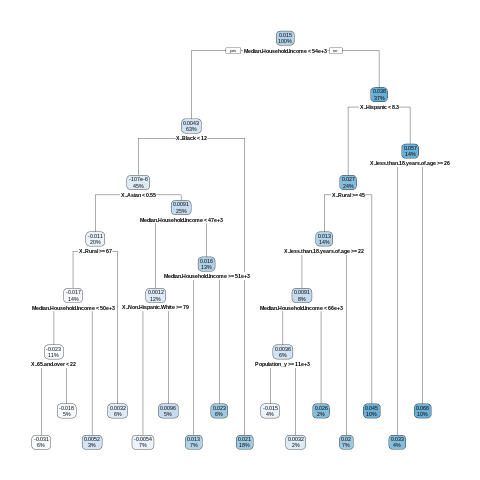

In [59]:
%%R
# let's try the same algorithm on a slightly less minsize.
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "CT", cv.option = "CT", split.Honest = T, cv.Honest = T,
                   split.Bucket = F, xval = 5, minsize = 20)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(opfit)

As we can see, decreaseing the `minsize` quickly makes the tree not interpretable. a `minsize` of `>= 50` seems reasonable in our case

In [60]:
%%R
print(tree$cptable)

             CP nsplit rel error    xerror         xstd
1  7.198209e-04      0 1.0000000 1.0000000 3.806346e-06
2  1.555385e-04      1 0.9992802 0.9994898 2.735428e-05
3  1.375977e-04      2 0.9991246 0.9994463 3.197943e-05
4  9.207516e-05      3 0.9989870 0.9993661 3.180514e-05
5  7.090403e-05      4 0.9988950 0.9993823 3.225638e-05
6  4.987639e-05      5 0.9988241 0.9993622 3.371847e-05
7  3.620088e-05      6 0.9987742 0.9993680 3.411962e-05
8  3.306797e-05      7 0.9987380 0.9994157 3.398992e-05
9  2.866823e-05      8 0.9987049 0.9994425 3.445883e-05
10 2.173940e-05      9 0.9986763 0.9994055 3.698709e-05
11 1.336507e-05     10 0.9986545 0.9993819 3.978906e-05
12 1.321574e-05     11 0.9986411 0.9993678 4.021331e-05
13 7.781740e-06     13 0.9986147 0.9993683 4.024190e-05
14 7.162960e-06     14 0.9986069 0.9993661 4.027520e-05
15 0.000000e+00     15 0.9985998 0.9993430 4.172654e-05


the interpretation of the above table is `CP` represents the complexity parameter?, and `xerror` means `normalized cross validation error`, which seems to suggest we are way off track because our `xerror` is very high! why???? Generally `xerror` should decrease as the tree splits.

Let's try out out parameters. Let's now try varying the splitting rule and see how things change

[1] 5
[1] "TOTD"
inside totDinit!
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside cont. split
totd: inside con

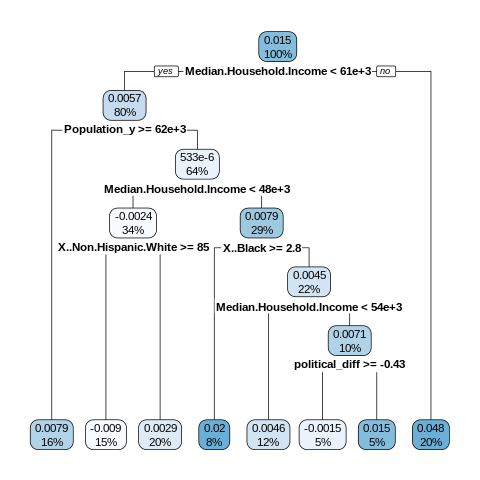

In [63]:
%%R
# TOT stands for Transformed Outcome Trees.
# TOT doesnt' have honest option.
# somehow TOT also requires propensity score parameter?
# split.Bucket = T means discrete splitting (which I don't quite understand yet)
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "TOT", cv.option = "fit", cv.Honest = F,
                   split.Bucket = T, xval = 5, cv.alpha = 0.5, propensity = 0.5, minsize = 50)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(tree)

In [64]:
%%R
print(tree$cptable)

            CP nsplit rel error    xerror        xstd
1 2.238801e-01      0 1.0000000 1.0000000 0.007927290
2 5.935806e-02      1 0.7761199 0.6807716 0.005421048
3 8.990568e-03      2 0.7167618 0.6285666 0.005172437
4 7.157957e-03      3 0.7077713 0.6057916 0.005085082
5 5.223274e-03      4 0.7006133 0.6040987 0.005068542
6 3.123502e-05      5 0.6953900 0.5907846 0.005011358
7 0.000000e+00      7 0.6953276 0.5896515 0.005024361


Woah, somehow this splitting rule of `TOT` decreased the `xerror` by a lot. Does that mean this is a better method? But notice that our cross validation metric changed from `CT` to `fit (fitness)`.

[1] 7
[1] "fitD"


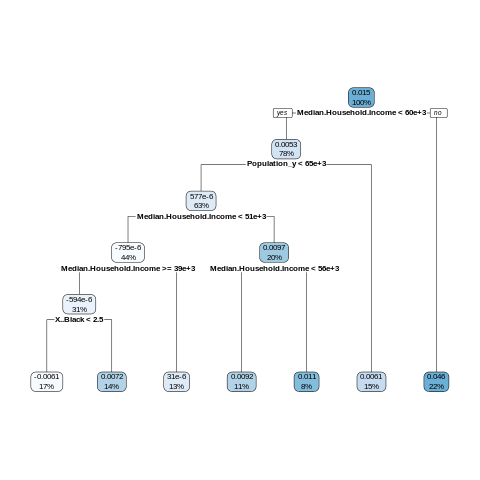

In [73]:
%%R
# using "fit" as splitting criterion
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "fit", cv.option = "fit", split.Honest = T, cv.Honest = F,
                   split.Bucket = T, xval = 5, cv.alpha = 0.5, minsize = 50)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(tree)

In [74]:
%%R
print(tree$cptable)

            CP nsplit rel error    xerror         xstd
1 1.289109e-03      0 1.0000000 1.0000000 0.0002905652
2 2.398617e-04      1 0.9987109 0.6704597 0.0001941668
3 8.321820e-05      2 0.9984710 0.6094957 0.0001839176
4 3.974664e-05      3 0.9983878 0.5859613 0.0001821102
5 1.024019e-05      4 0.9983481 0.5838301 0.0001803973
6 7.332691e-06      5 0.9983378 0.5796453 0.0001801938
7 0.000000e+00      6 0.9983305 0.5802438 0.0001802963


[1] 7
[1] "fitD"


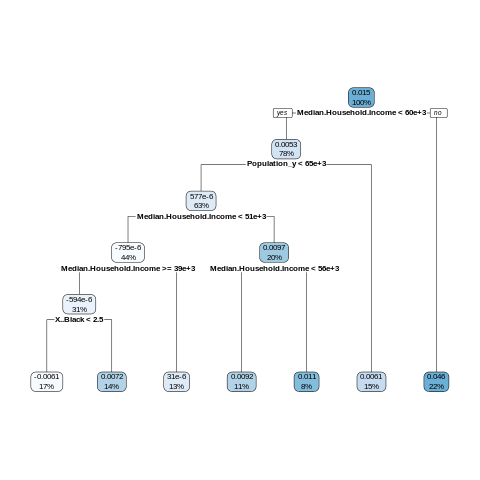

In [75]:
%%R
# using "fit" as splitting criterion
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "fit", cv.option = "fit", split.Honest = T, cv.Honest = T,
                   split.Bucket = T, xval = 5, cv.alpha = 0.5, minsize = 50)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(tree)

In [76]:
%%R
print(tree$cptable)

            CP nsplit rel error    xerror         xstd
1 1.289109e-03      0 1.0000000 1.0000000 1.149361e-05
2 2.398617e-04      1 0.9987109 0.9987224 9.828053e-05
3 8.321820e-05      2 0.9984710 0.9984976 9.872019e-05
4 3.974664e-05      3 0.9983878 0.9984112 9.800282e-05
5 1.024019e-05      4 0.9983481 0.9984085 9.796913e-05
6 7.332691e-06      5 0.9983378 0.9984077 9.800046e-05
7 0.000000e+00      6 0.9983305 0.9984005 9.804270e-05


it turns out dropped `xerror` is in some sense caused by `cv.Honest = F` don't know why this is yet.

[1] 8
[1] "tstatsD"


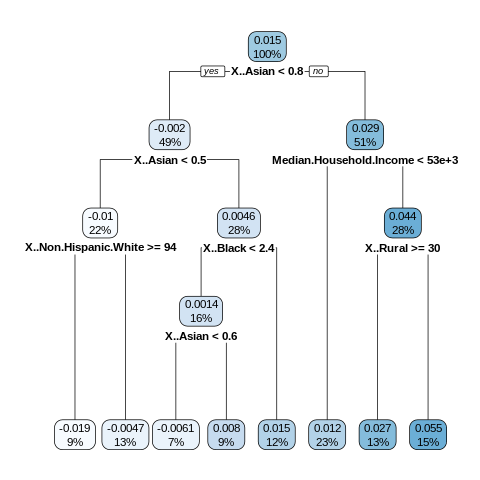

In [77]:
%%R
# using "tstats" as splitting criterion
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "tstats", cv.option = "fit", split.Honest = T, cv.Honest = T,
                   split.Bucket = T, xval = 5, cv.alpha = 0.5, minsize = 50)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(tree)

In [78]:
%%R
print(tree$cptable)

            CP nsplit rel error    xerror         xstd
1 4.101955e-04      0 1.0000000 1.0000000 1.169790e-05
2 3.359335e-04      1 0.9995898 0.9994614 5.023884e-05
3 5.303473e-05      2 0.9992539 0.9988824 8.208687e-05
4 3.682779e-05      3 0.9992008 0.9988354 8.202501e-05
5 1.408357e-05      4 0.9991640 0.9988282 8.196411e-05
6 9.715576e-06      5 0.9991499 0.9988071 8.187684e-05
7 5.810953e-06      6 0.9991402 0.9988071 8.187684e-05
8 0.000000e+00      7 0.9991344 0.9988012 8.181294e-05


[1] 4
[1] "tstats"


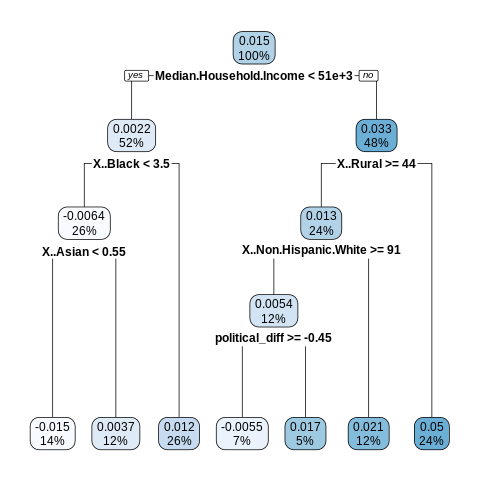

In [83]:
%%R
# using "tstats" as splitting criterion
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "tstats", cv.option = "fit", split.Honest = T, cv.Honest = T,
                   xval = 5, minsize = 50)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(tree)

In [84]:
%%R
print(tree$cptable)

            CP nsplit rel error    xerror         xstd
1 6.605951e-04      0 1.0000000 1.0000000 1.219462e-05
2 2.349627e-04      1 0.9993394 0.9990214 6.518513e-05
3 9.805651e-05      2 0.9991044 0.9988016 8.275015e-05
4 4.147427e-05      3 0.9990064 0.9987766 8.317338e-05
5 3.691223e-05      4 0.9989649 0.9987454 8.434021e-05
6 2.620240e-05      5 0.9989280 0.9987454 8.434021e-05
7 0.000000e+00      6 0.9989018 0.9987245 8.458793e-05


[1] 2
[1] "CT"


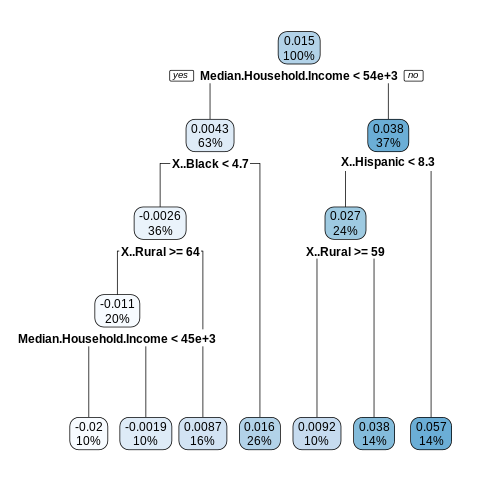

In [95]:
%%R
# using "matching" as cross validation method
tree <- causalTree(formula, data = data, treatment = data$SIP.,
                   split.Rule = "CT", cv.option = "matching", split.Honest = T, cv.Honest = F,
                   split.Bucket = F, xval = 5, minsize = 50)

opcp <- tree$cptable[,1][which.min(tree$cptable[,4])]

opfit <- prune(tree, opcp)

rpart.plot(tree)

In [96]:
%%R
print(tree$cptable)

            CP nsplit rel error   xerror         xstd
1 7.198209e-04      0 1.0000000 1.000000 0.0002783375
2 1.555385e-04      1 0.9992802 1.199042 0.0002948801
3 1.165893e-04      2 0.9991246 1.176809 0.0002948088
4 7.248415e-05      3 0.9990081 1.140677 0.0002893569
5 3.773485e-05      4 0.9989356 1.145588 0.0002893669
6 2.632330e-05      5 0.9988978 1.144033 0.0002889473
7 0.000000e+00      6 0.9988715 1.148067 0.0002908421


Conclusion is:

Median household income seems to be one of the most important covaraite that impacts the efficacy of the government's policy's impact in various causal tree models we constructed. High median household income counties seem to have higher treatment effects. **Although there currently lacks a way to fully evaluate how good these causal tree models are**, this is still a very interesting way to see non-uniform treatment effects!

We didn't attempt to use causal forest or propensity forest because that is used for predicting the causal effect given a new instance, and doesn't give us heterogeneous effects (causal forest will build multiple causal trees, how do we interpret those trees together?)